In [78]:
import pandas as pd
import requests

# 🔹 1. Cargar DXY
dxy = pd.read_csv('DXY_Index.csv', skiprows=1, header=None)
dxy.columns = ['Fecha', 'DXY']
dxy['Fecha'] = pd.to_datetime(dxy['Fecha'], errors='coerce')
dxy = dxy.dropna()

# 🔹 2. Cargar VIX
vix = pd.read_csv('VIX_History.csv', parse_dates=['DATE'], dayfirst=True)
vix = vix[['DATE', 'CLOSE']].rename(columns={'DATE': 'Fecha', 'CLOSE': 'VIX'})
vix['Fecha'] = pd.to_datetime(vix['Fecha'], errors='coerce')
vix = vix.dropna()

# 🔹 3. Cargar inflación USA
inflacion = pd.read_csv('Inflacion_USA.csv', parse_dates=['Fecha'])
inflacion = inflacion.rename(columns={'Inflación USA': 'Inflacion_USA'})
inflacion['Fecha'] = inflacion['Fecha'].dt.to_period('M').dt.to_timestamp()

# 🔹 4. Cargar tasa FED desde API FRED
api_key = '437ffc22620f0fe3615350b1764f112b'
url = f'https://api.stlouisfed.org/fred/series/observations?series_id=FEDFUNDS&api_key={api_key}&file_type=json'
response = requests.get(url)
data = response.json()

fed_data = pd.DataFrame(data['observations'])
fed_data = fed_data[['date', 'value']].rename(columns={'date': 'Fecha', 'value': 'Tasa_FED'})
fed_data['Fecha'] = pd.to_datetime(fed_data['Fecha'], errors='coerce')
fed_data['Tasa_FED'] = pd.to_numeric(fed_data['Tasa_FED'], errors='coerce')
fed_data['Fecha'] = fed_data['Fecha'].dt.to_period('M').dt.to_timestamp()
fed_data = fed_data.groupby('Fecha').mean().reset_index()

# 🔹 5. Unir todos los datasets
df = pd.merge(dxy, vix, on='Fecha', how='left')
df = pd.merge(df, inflacion, on='Fecha', how='left')
df = pd.merge(df, fed_data, on='Fecha', how='left')

# 🔹 6. Rellenar valores faltantes
df['Inflacion_USA'] = df['Inflacion_USA'].fillna(method='ffill')
df['Tasa_FED'] = df['Tasa_FED'].fillna(method='ffill')
df['VIX'] = df['VIX'].interpolate(method='linear')

# 🔹 7. Variables derivadas
df['dia_semana'] = df['Fecha'].dt.dayofweek
df['mes'] = df['Fecha'].dt.month
df['año'] = df['Fecha'].dt.year

# 🔹 8. Mostrar muestra
df = df.sort_values('Fecha').reset_index(drop=True)
df.head()


C:\Users\cpuertas\AppData\Local\Temp\ipykernel_1556\592489974.py:7: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\cpuertas\AppData\Local\Temp\ipykernel_1556\592489974.py:40: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\cpuertas\AppData\Local\Temp\ipykernel_1556\592489974.py:41: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Fecha,DXY,VIX,Inflacion_USA,Tasa_FED,dia_semana,mes,año
0,2010-01-04,77.52999877929688,20.04,NaN,NaN,0,1,2010
1,2010-01-05,77.62000274658203,19.35,NaN,NaN,1,1,2010
2,2010-01-06,77.48999786376953,19.16,NaN,NaN,2,1,2010
3,2010-01-07,77.91000366210938,19.06,NaN,NaN,3,1,2010
4,2010-01-08,77.47000122070312,18.13,NaN,NaN,4,1,2010


In [79]:
dxy['Fecha'] = pd.to_datetime(dxy['Fecha'], format='%Y-%m-%d', errors='coerce')


In [80]:
df['Inflacion_USA'] = df['Inflacion_USA'].ffill()
df['Tasa_FED'] = df['Tasa_FED'].ffill()


In [81]:
from prophet import Prophet

# Preparar datos para Prophet
df_prophet = df[['Fecha', 'DXY']].rename(columns={'Fecha': 'ds', 'DXY': 'y'})

# Entrenar modelo Prophet
model = Prophet()
model.fit(df_prophet)

# Simular 365 días hacia adelante
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Extraer variables clave
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['dispersión'] = forecast['yhat_upper'] - forecast['yhat_lower']


13:13:18 - cmdstanpy - INFO - Chain [1] start processing
13:13:21 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
forecast

,ds,yhat,yhat_lower,yhat_upper,dispersión
0,2010-01-04,79.446167,77.247330,81.588622,4.341292
1,2010-01-05,79.471933,77.224170,81.912860,4.688689
2,2010-01-06,79.458267,77.135675,81.765466,4.629791
3,2010-01-07,79.467193,77.057917,81.706895,4.648978
4,2010-01-08,79.501753,77.166916,81.663474,4.496558
...,...,...,...,...,...
4268,2026-07-12,100.323682,89.841344,111.740364,21.899020
4269,2026-07-13,101.512087,91.286343,112.506091,21.219748
4270,2026-07-14,101.517038,90.812664,113.284810,22.472145
4271,2026-07-15,101.481845,91.524985,113.083113,21.558128


In [83]:
# Renombrar columna de fecha en forecast para unir
forecast = forecast.rename(columns={'ds': 'Fecha'})

# Unir forecast con datos económicos
df_modelo = pd.merge(df, forecast, on='Fecha', how='inner')

# Crear etiqueta de decisión (regla inicial)
def etiquetar_decision(row):
    if row['yhat'] > row['yhat_upper'] - 0.01 and row['dispersión'] < 10:
        return 'cambiar'
    elif row['yhat'] < row['yhat_lower'] + 0.01 and row['dispersión'] < 10:
        return 'no_cambiar'
    else:
        return 'evaluar'

df_modelo['decision'] = df_modelo.apply(etiquetar_decision, axis=1)


In [85]:
df

,Fecha,DXY,VIX,Inflacion_USA,Tasa_FED,dia_semana,mes,año
0,2010-01-04,77.52999877929688,20.04,NaN,NaN,0,1,2010
1,2010-01-05,77.62000274658203,19.35,NaN,NaN,1,1,2010
2,2010-01-06,77.48999786376953,19.16,NaN,NaN,2,1,2010
3,2010-01-07,77.91000366210938,19.06,NaN,NaN,3,1,2010
4,2010-01-08,77.47000122070312,18.13,NaN,NaN,4,1,2010
...,...,...,...,...,...,...,...,...
3903,2025-07-10,97.6500015258789,15.78,320.58,4.33,3,7,2025
3904,2025-07-11,97.8499984741211,16.40,320.58,4.33,4,7,2025
3905,2025-07-14,98.08000183105469,17.20,320.58,4.33,0,7,2025
3906,2025-07-15,98.62000274658203,17.38,320.58,4.33,1,7,2025


In [86]:
# Renombrar columna de fecha en forecast
forecast = forecast.rename(columns={'ds': 'Fecha'})

# Unir con DataFrame económico
df_modelo = pd.merge(df, forecast, on='Fecha', how='inner')

# Crear etiqueta de decisión (regla inicial)
def etiquetar_decision(row):
    if row['yhat'] > row['yhat_upper'] - 0.01 and row['dispersión'] < 10:
        return 'cambiar'
    elif row['yhat'] < row['yhat_lower'] + 0.01 and row['dispersión'] < 10:
        return 'no_cambiar'
    else:
        return 'evaluar'

df_modelo['decision'] = df_modelo.apply(etiquetar_decision, axis=1)

# Mostrar muestra
df_modelo[['Fecha', 'DXY', 'yhat', 'dispersión', 'decision']].tail()


,Fecha,DXY,yhat,dispersión,decision
3903,2025-07-10,97.6500015258789,102.478425,4.403868,evaluar
3904,2025-07-11,97.8499984741211,102.501872,4.441083,evaluar
3905,2025-07-14,98.08000183105469,102.447328,4.657012,evaluar
3906,2025-07-15,98.62000274658203,102.449741,4.687083,evaluar
3907,2025-07-16,98.38999938964844,102.412204,4.505159,evaluar


# Version 2 nuevas etiquetas
---


13:25:41 - cmdstanpy - INFO - Chain [1] start processing
13:25:44 - cmdstanpy - INFO - Chain [1] done processing


Distribución de clases: {np.int64(0): np.int64(359), np.int64(1): np.int64(392), np.int64(2): np.int64(3157)}


C:\Users\cpuertas\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning:

[13:25:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




📊 Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.15      0.02      0.04        88
           2       0.82      0.97      0.89       640

    accuracy                           0.80       782
   macro avg       0.32      0.33      0.31       782
weighted avg       0.69      0.80      0.73       782

📊 XGBoost
              precision    recall  f1-score   support

           0       0.07      0.02      0.03        54
           1       0.10      0.02      0.04        88
           2       0.82      0.95      0.88       640

    accuracy                           0.78       782
   macro avg       0.33      0.33      0.32       782
weighted avg       0.68      0.78      0.73       782



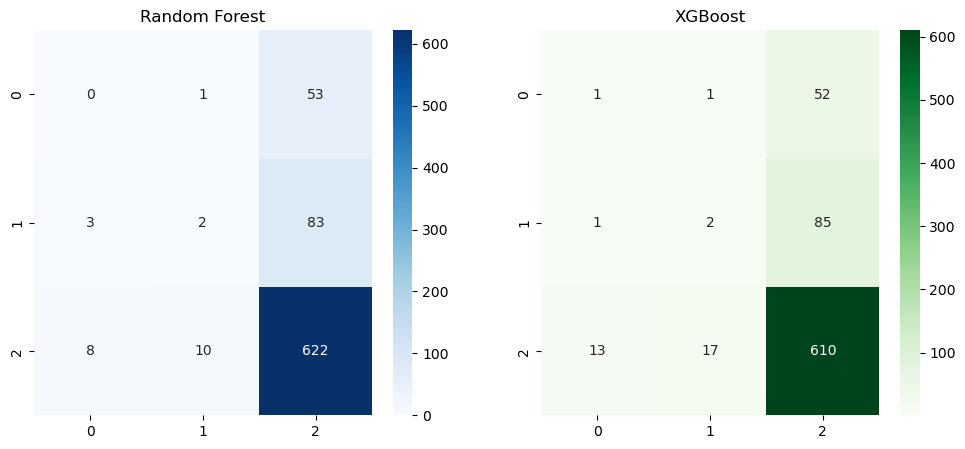

In [94]:
import pandas as pd
import numpy as np
import requests
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 1. Cargar DXY
dxy = pd.read_csv('DXY_Index.csv', skiprows=1, header=None)
dxy.columns = ['Fecha', 'DXY']
dxy['Fecha'] = pd.to_datetime(dxy['Fecha'], format='%Y-%m-%d', errors='coerce')
dxy['DXY'] = pd.to_numeric(dxy['DXY'], errors='coerce')
dxy = dxy.dropna()

# 🔹 2. Cargar VIX
vix = pd.read_csv('VIX_History.csv', parse_dates=['DATE'], dayfirst=True)
vix = vix[['DATE', 'CLOSE']].rename(columns={'DATE': 'Fecha', 'CLOSE': 'VIX'})
vix['Fecha'] = pd.to_datetime(vix['Fecha'], errors='coerce')
vix['VIX'] = pd.to_numeric(vix['VIX'], errors='coerce')
vix = vix.dropna()

# 🔹 3. Cargar inflación
inflacion = pd.read_csv('Inflacion_USA.csv', parse_dates=['Fecha'])
inflacion = inflacion.rename(columns={'Inflación USA': 'Inflacion_USA'})
inflacion['Fecha'] = inflacion['Fecha'].dt.to_period('M').dt.to_timestamp()
inflacion['Inflacion_USA'] = pd.to_numeric(inflacion['Inflacion_USA'], errors='coerce')

# 🔹 4. Cargar tasa FED desde FRED API
api_key = '437ffc22620f0fe3615350b1764f112b'
url = f'https://api.stlouisfed.org/fred/series/observations?series_id=FEDFUNDS&api_key={api_key}&file_type=json'
response = requests.get(url)
data = response.json()

fed_data = pd.DataFrame(data['observations'])
fed_data = fed_data[['date', 'value']].rename(columns={'date': 'Fecha', 'value': 'Tasa_FED'})
fed_data['Fecha'] = pd.to_datetime(fed_data['Fecha'], errors='coerce')
fed_data['Tasa_FED'] = pd.to_numeric(fed_data['Tasa_FED'], errors='coerce')
fed_data['Fecha'] = fed_data['Fecha'].dt.to_period('M').dt.to_timestamp()
fed_data = fed_data.groupby('Fecha').mean().reset_index()

# 🔹 5. Unir todos los datos
df = pd.merge(dxy, vix, on='Fecha', how='left')
df = pd.merge(df, inflacion, on='Fecha', how='left')
df = pd.merge(df, fed_data, on='Fecha', how='left')

# 🔹 6. Rellenar y derivar variables
df['Inflacion_USA'] = df['Inflacion_USA'].ffill()
df['Tasa_FED'] = df['Tasa_FED'].ffill()
df['VIX'] = df['VIX'].interpolate(method='linear')
df['dia_semana'] = df['Fecha'].dt.dayofweek
df['mes'] = df['Fecha'].dt.month
df['año'] = df['Fecha'].dt.year

# 🔹 7. Entrenar Prophet
df_prophet = df[['Fecha', 'DXY']].rename(columns={'Fecha': 'ds', 'DXY': 'y'})
model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['dispersión'] = forecast['yhat_upper'] - forecast['yhat_lower']
forecast = forecast.rename(columns={'ds': 'Fecha'})

# 🔹 8. Unir forecast con datos económicos
df_modelo = pd.merge(df, forecast, on='Fecha', how='inner')

# 🔹 9. Etiquetar decisiones por variación real del DXY
df_modelo['DXY'] = pd.to_numeric(df_modelo['DXY'], errors='coerce')
df_modelo['DXY_prev'] = df_modelo['DXY'].shift(1)
df_modelo['variacion'] = df_modelo['DXY'] - df_modelo['DXY_prev']

def etiquetar_por_variacion(row):
    if row['variacion'] > 0.5:
        return 'cambiar'
    elif row['variacion'] < -0.5:
        return 'no_cambiar'
    else:
        return 'evaluar'

df_modelo['decision'] = df_modelo.apply(etiquetar_por_variacion, axis=1)

# 🔹 10. Codificar y verificar distribución
y_encoded = df_modelo['decision'].map({'cambiar': 1, 'no_cambiar': 0, 'evaluar': 2})
unique, counts = np.unique(y_encoded.dropna(), return_counts=True)
print("Distribución de clases:", dict(zip(unique, counts)))

# 🔹 11. Separar features y target
features = ['DXY', 'VIX', 'Inflacion_USA', 'Tasa_FED', 'dia_semana', 'mes', 'año', 'yhat', 'dispersión']
X = df_modelo[features]
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 12. Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# 🔹 13. Entrenar XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# 🔹 14. Evaluar modelos
print("📊 Random Forest")
print(classification_report(y_test, rf_pred))
print("📊 XGBoost")
print(classification_report(y_test, xgb_pred))

# 🔹 15. Matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Random Forest')
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title('XGBoost')
plt.show()


# version 3
---

13:33:58 - cmdstanpy - INFO - Chain [1] start processing
13:34:00 - cmdstanpy - INFO - Chain [1] done processing


📊 Random Forest
              precision    recall  f1-score   support

           0       0.55      0.51      0.53       174
           1       0.49      0.53      0.51       153

    accuracy                           0.52       327
   macro avg       0.52      0.52      0.52       327
weighted avg       0.52      0.52      0.52       327

📊 XGBoost
              precision    recall  f1-score   support

           0       0.55      0.52      0.54       174
           1       0.48      0.51      0.50       153

    accuracy                           0.52       327
   macro avg       0.52      0.52      0.52       327
weighted avg       0.52      0.52      0.52       327



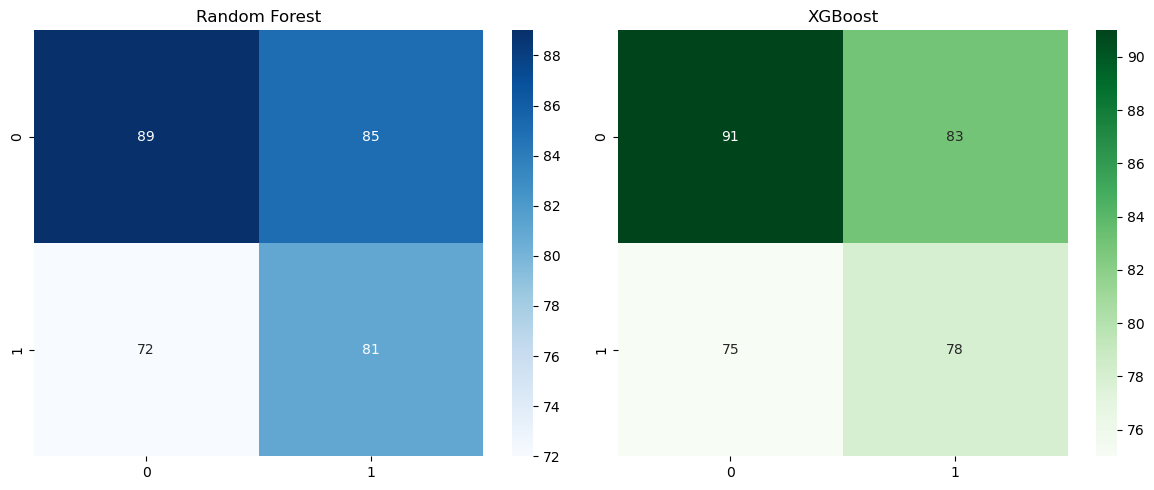

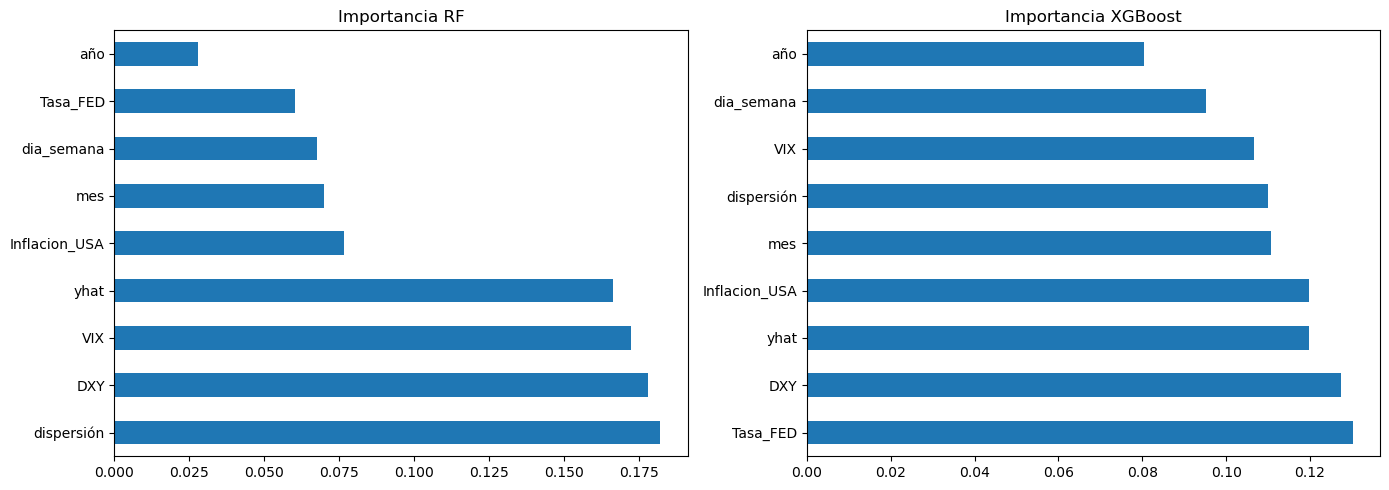

In [96]:
import pandas as pd
import numpy as np
import requests
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 1. Cargar y preparar datos económicos
dxy = pd.read_csv('DXY_Index.csv', skiprows=1, header=None)
dxy.columns = ['Fecha', 'DXY']
dxy['Fecha'] = pd.to_datetime(dxy['Fecha'], format='%Y-%m-%d', errors='coerce')
dxy['DXY'] = pd.to_numeric(dxy['DXY'], errors='coerce')
dxy = dxy.dropna()

vix = pd.read_csv('VIX_History.csv', parse_dates=['DATE'], dayfirst=True)
vix = vix[['DATE', 'CLOSE']].rename(columns={'DATE': 'Fecha', 'CLOSE': 'VIX'})
vix['Fecha'] = pd.to_datetime(vix['Fecha'], errors='coerce')
vix['VIX'] = pd.to_numeric(vix['VIX'], errors='coerce')
vix = vix.dropna()

inflacion = pd.read_csv('Inflacion_USA.csv', parse_dates=['Fecha'])
inflacion = inflacion.rename(columns={'Inflación USA': 'Inflacion_USA'})
inflacion['Fecha'] = inflacion['Fecha'].dt.to_period('M').dt.to_timestamp()
inflacion['Inflacion_USA'] = pd.to_numeric(inflacion['Inflacion_USA'], errors='coerce')

api_key = '437ffc22620f0fe3615350b1764f112b'
url = f'https://api.stlouisfed.org/fred/series/observations?series_id=FEDFUNDS&api_key={api_key}&file_type=json'
response = requests.get(url)
data = response.json()

fed_data = pd.DataFrame(data['observations'])
fed_data = fed_data[['date', 'value']].rename(columns={'date': 'Fecha', 'value': 'Tasa_FED'})
fed_data['Fecha'] = pd.to_datetime(fed_data['Fecha'], errors='coerce')
fed_data['Tasa_FED'] = pd.to_numeric(fed_data['Tasa_FED'], errors='coerce')
fed_data['Fecha'] = fed_data['Fecha'].dt.to_period('M').dt.to_timestamp()
fed_data = fed_data.groupby('Fecha').mean().reset_index()

df = pd.merge(dxy, vix, on='Fecha', how='left')
df = pd.merge(df, inflacion, on='Fecha', how='left')
df = pd.merge(df, fed_data, on='Fecha', how='left')
df['Inflacion_USA'] = df['Inflacion_USA'].ffill()
df['Tasa_FED'] = df['Tasa_FED'].ffill()
df['VIX'] = df['VIX'].interpolate(method='linear')
df['dia_semana'] = df['Fecha'].dt.dayofweek
df['mes'] = df['Fecha'].dt.month
df['año'] = df['Fecha'].dt.year

# 🔹 2. Entrenar Prophet
df_prophet = df[['Fecha', 'DXY']].rename(columns={'Fecha': 'ds', 'DXY': 'y'})
model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['dispersión'] = forecast['yhat_upper'] - forecast['yhat_lower']
forecast = forecast.rename(columns={'ds': 'Fecha'})

# 🔹 3. Unir y etiquetar decisiones binarias
df_modelo = pd.merge(df, forecast, on='Fecha', how='inner')
df_modelo['DXY_prev'] = df_modelo['DXY'].shift(1)
df_modelo['variacion'] = df_modelo['DXY'] - df_modelo['DXY_prev']

def etiquetar_binario(row):
    if row['variacion'] > 0.3:
        return 'cambiar'
    elif row['variacion'] < -0.3:
        return 'no_cambiar'
    else:
        return None

df_modelo['decision'] = df_modelo.apply(etiquetar_binario, axis=1)
df_bin = df_modelo.dropna(subset=['decision'])
y_bin = df_bin['decision'].map({'cambiar': 1, 'no_cambiar': 0})
X_bin = df_bin[['DXY', 'VIX', 'Inflacion_USA', 'Tasa_FED', 'dia_semana', 'mes', 'año', 'yhat', 'dispersión']]

# 🔹 4. Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
X_bin_clean = pd.DataFrame(imputer.fit_transform(X_bin), columns=X_bin.columns)

# 🔹 5. Balancear clases con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_bin_clean, y_bin)

# 🔹 6. Separar datos
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 🔹 7. Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# 🔹 8. Entrenar XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# 🔹 9. Evaluar modelos
print("📊 Random Forest")
print(classification_report(y_test, rf_pred))
print("📊 XGBoost")
print(classification_report(y_test, xgb_pred))

# 🔹 10. Matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Random Forest')
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title('XGBoost')
plt.tight_layout()
plt.show()

# 🔹 11. Importancia de variables
importances_rf = pd.Series(rf.feature_importances_, index=X_bin.columns).sort_values(ascending=False)
importances_xgb = pd.Series(xgb.feature_importances_, index=X_bin.columns).sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
importances_rf.plot(kind='barh', ax=ax[0], title='Importancia RF')
importances_xgb.plot(kind='barh', ax=ax[1], title='Importancia XGBoost')
plt.tight_layout()
plt.show()


# Estrategia combinada
---


13:37:34 - cmdstanpy - INFO - Chain [1] start processing
13:37:37 - cmdstanpy - INFO - Chain [1] done processing


📊 Modelo combinado Prophet + Random Forest
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       176
           1       0.50      0.53      0.51       150

    accuracy                           0.54       326
   macro avg       0.54      0.54      0.54       326
weighted avg       0.54      0.54      0.54       326



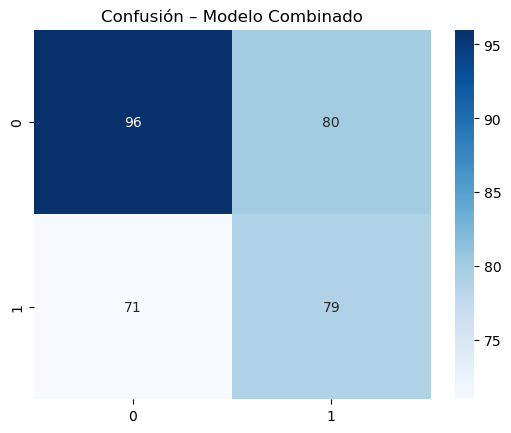

In [97]:
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 🔹 1. Preparar datos para Prophet con regresores
df_reg = df[['Fecha', 'DXY', 'VIX', 'Inflacion_USA', 'Tasa_FED']].dropna()
df_reg = df_reg.rename(columns={'Fecha': 'ds', 'DXY': 'y'})

# 🔹 2. Reentrenar Prophet con regresores
model = Prophet()
model.add_regressor('VIX')
model.add_regressor('Inflacion_USA')
model.add_regressor('Tasa_FED')
model.fit(df_reg)

# 🔹 3. Crear futuro con regresores
future = df_reg[['ds', 'VIX', 'Inflacion_USA', 'Tasa_FED']].copy()
forecast = model.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['dispersión'] = forecast['yhat_upper'] - forecast['yhat_lower']
forecast = forecast.rename(columns={'ds': 'Fecha'})

# 🔹 4. Unir con datos económicos
df_modelo = pd.merge(df, forecast, on='Fecha', how='inner')
df_modelo['DXY_prev'] = df_modelo['DXY'].shift(1)
df_modelo['variacion'] = df_modelo['DXY'] - df_modelo['DXY_prev']

# 🔹 5. Etiquetar decisiones binarias
def etiquetar_binario(row):
    if row['variacion'] > 0.3:
        return 'cambiar'
    elif row['variacion'] < -0.3:
        return 'no_cambiar'
    else:
        return None

df_modelo['decision'] = df_modelo.apply(etiquetar_binario, axis=1)
df_bin = df_modelo.dropna(subset=['decision'])
y_bin = df_bin['decision'].map({'cambiar': 1, 'no_cambiar': 0})

# 🔹 6. Features para clasificador
X_bin = df_bin[['DXY', 'VIX', 'Inflacion_USA', 'Tasa_FED', 'dia_semana', 'mes', 'año', 'yhat', 'dispersión']]

# 🔹 7. Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
X_bin_clean = pd.DataFrame(imputer.fit_transform(X_bin), columns=X_bin.columns)

# 🔹 8. Balancear clases con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_bin_clean, y_bin)

# 🔹 9. Entrenar Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# 🔹 10. Evaluar rendimiento
print("📊 Modelo combinado Prophet + Random Forest")
print(classification_report(y_test, rf_pred))

# 🔹 11. Matriz de confusión
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusión – Modelo Combinado')
plt.show()


# Implementación de mejora


13:39:26 - cmdstanpy - INFO - Chain [1] start processing
13:39:30 - cmdstanpy - INFO - Chain [1] done processing


📊 Accuracy promedio (TimeSeriesSplit): 49.90%
📊 Última partición:
              precision    recall  f1-score   support

           0       0.60      0.18      0.27       157
           1       0.47      0.86      0.60       132

    accuracy                           0.49       289
   macro avg       0.53      0.52      0.44       289
weighted avg       0.54      0.49      0.43       289



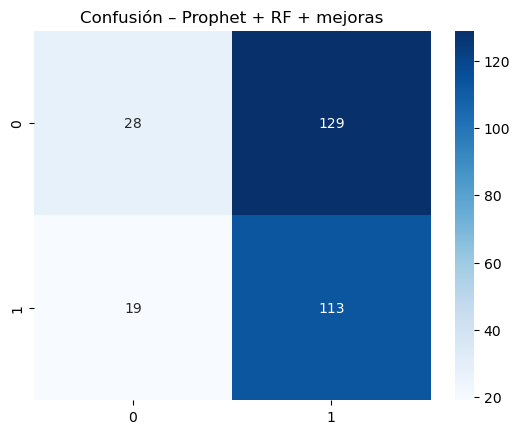

In [98]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 1. Reentrenar Prophet con regresores
df_reg = df[['Fecha', 'DXY', 'VIX', 'Inflacion_USA', 'Tasa_FED']].dropna()
df_reg = df_reg.rename(columns={'Fecha': 'ds', 'DXY': 'y'})

model = Prophet()
model.add_regressor('VIX')
model.add_regressor('Inflacion_USA')
model.add_regressor('Tasa_FED')
model.fit(df_reg)

future = df_reg[['ds', 'VIX', 'Inflacion_USA', 'Tasa_FED']]
forecast = model.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['dispersión'] = forecast['yhat_upper'] - forecast['yhat_lower']
forecast = forecast.rename(columns={'ds': 'Fecha'})

# 🔹 2. Unir con datos económicos
df_modelo = pd.merge(df, forecast, on='Fecha', how='inner')
df_modelo['DXY_prev'] = df_modelo['DXY'].shift(1)
df_modelo['variacion'] = df_modelo['DXY'] - df_modelo['DXY_prev']

# 🔹 3. Etiquetado con variación relativa
def etiquetar_binario(row):
    if row['variacion'] > row['DXY'] * 0.003:
        return 'cambiar'
    elif row['variacion'] < -row['DXY'] * 0.003:
        return 'no_cambiar'
    else:
        return None

df_modelo['decision'] = df_modelo.apply(etiquetar_binario, axis=1)
df_bin = df_modelo.dropna(subset=['decision'])
y_bin = df_bin['decision'].map({'cambiar': 1, 'no_cambiar': 0})

# 🔹 4. Features para clasificador
X_bin = df_bin[['DXY', 'VIX', 'Inflacion_USA', 'Tasa_FED', 'dia_semana', 'mes', 'año', 'yhat', 'dispersión']]

# 🔹 5. Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
X_bin_clean = pd.DataFrame(imputer.fit_transform(X_bin), columns=X_bin.columns)

# 🔹 6. Balancear clases con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_bin_clean, y_bin)

# 🔹 7. Validación temporal con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
accuracies = []
reports = []

for train_index, test_index in tscv.split(X_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    acc = (y_pred == y_test).mean()
    accuracies.append(acc)
    reports.append(classification_report(y_test, y_pred, output_dict=True))

# 🔹 8. Mostrar resultados
print(f"📊 Accuracy promedio (TimeSeriesSplit): {np.mean(accuracies)*100:.2f}%")

# 🔹 9. Último reporte detallado
last_report = reports[-1]
print("📊 Última partición:")
print(classification_report(y_test, y_pred))

# 🔹 10. Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusión – Prophet + RF + mejoras')
plt.show()


13:44:12 - cmdstanpy - INFO - Chain [1] start processing
13:44:15 - cmdstanpy - INFO - Chain [1] done processing


📊 Accuracy promedio ajustado (TimeSeriesSplit): 50.45%
📊 Última partición:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47       157
           1       0.51      0.79      0.62       132

    accuracy                           0.56       289
   macro avg       0.59      0.58      0.55       289
weighted avg       0.60      0.56      0.54       289



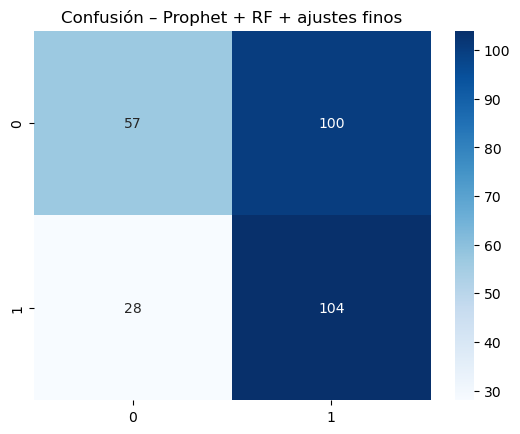

In [99]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 1. Reentrenar Prophet con regresores
df_reg = df[['Fecha', 'DXY', 'VIX', 'Inflacion_USA', 'Tasa_FED']].dropna()
df_reg = df_reg.rename(columns={'Fecha': 'ds', 'DXY': 'y'})

model = Prophet()
model.add_regressor('VIX')
model.add_regressor('Inflacion_USA')
model.add_regressor('Tasa_FED')
model.fit(df_reg)

future = df_reg[['ds', 'VIX', 'Inflacion_USA', 'Tasa_FED']]
forecast = model.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['dispersión'] = forecast['yhat_upper'] - forecast['yhat_lower']
forecast['confianza_prophet'] = 1 / forecast['dispersión']
forecast = forecast.rename(columns={'ds': 'Fecha'})

# 🔹 2. Unir con datos económicos
df_modelo = pd.merge(df, forecast, on='Fecha', how='inner')
df_modelo['DXY_prev'] = df_modelo['DXY'].shift(1)
df_modelo['variacion'] = df_modelo['DXY'] - df_modelo['DXY_prev']

# 🔹 3. Etiquetado con variación relativa
def etiquetar_binario(row):
    if row['variacion'] > row['DXY'] * 0.003:
        return 'cambiar'
    elif row['variacion'] < -row['DXY'] * 0.003:
        return 'no_cambiar'
    else:
        return None

df_modelo['decision'] = df_modelo.apply(etiquetar_binario, axis=1)
df_bin = df_modelo.dropna(subset=['decision'])
y_bin = df_bin['decision'].map({'cambiar': 1, 'no_cambiar': 0})

# 🔹 4. Filtrar días con alta dispersión
df_bin = df_bin[df_bin['dispersión'] < 10]

# 🔹 5. Features para clasificador
X_bin = df_bin[['DXY', 'VIX', 'Inflacion_USA', 'Tasa_FED', 'dia_semana', 'mes', 'año', 'yhat', 'dispersión', 'confianza_prophet']]

# 🔹 6. Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
X_bin_clean = pd.DataFrame(imputer.fit_transform(X_bin), columns=X_bin.columns)

# 🔹 7. Balancear clases con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_bin_clean, y_bin)

# 🔹 8. Validación temporal con ajuste de umbral
tscv = TimeSeriesSplit(n_splits=5)
accuracies = []
reports = []

for train_index, test_index in tscv.split(X_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    rf = RandomForestClassifier(n_estimators=100, class_weight={0: 2, 1: 1}, random_state=42)
    rf.fit(X_train, y_train)
    y_proba = rf.predict_proba(X_test)
    y_pred_adjusted = (y_proba[:, 1] > 0.6).astype(int)

    acc = (y_pred_adjusted == y_test).mean()
    accuracies.append(acc)
    reports.append(classification_report(y_test, y_pred_adjusted, output_dict=True))

# 🔹 9. Mostrar resultados
print(f"📊 Accuracy promedio ajustado (TimeSeriesSplit): {np.mean(accuracies)*100:.2f}%")

# 🔹 10. Última partición detallada
last_report = reports[-1]
print("📊 Última partición:")
print(classification_report(y_test, y_pred_adjusted))

# 🔹 11. Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Blues')
plt.title('Confusión – Prophet + RF + ajustes finos')
plt.show()


# Comparativa de fiabilidad en julio 2025

In [101]:
import joblib

# 🔹 Guardar modelo Random Forest
joblib.dump(rf, 'modelo_rf_julio.pkl')

# 🔹 Guardar imputador
joblib.dump(imputer, 'imputador.pkl')

# 🔹 Guardar columnas de features
features = X_bin.columns.tolist()
joblib.dump(features, 'features_rf.pkl')

print("✅ Modelo, imputador y columnas guardados para Streamlit")


✅ Modelo, imputador y columnas guardados para Streamlit
